# Problem Set 1 (92 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

# Problem 1 (Time series forecasting with simple NLA) (31 pts)

Many daily-life events can be described using **time series**: $x_t$, $t \in \{0, \ldots, n\}$, e.g.
closing price of a stock on day $t$ or number of users on a website in hour $t$.

Below you are given time series example $x \in \mathbb{R}^n$:

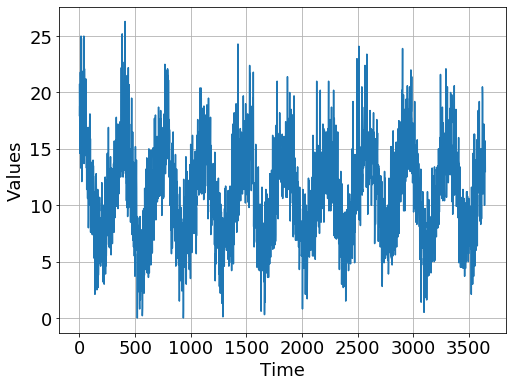

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('https://nla.skoltech.ru/homeworks/files/data.csv')
x = data['Val'].values
plt.figure(figsize=(8, 6))
plt.plot(x)
plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

Raw time dependent data usually looks rather unpretty. However, it can be often considered as a sum of some **trend** + some random **noise**. For example, a periodic trend is easily observed in the series above.

_1._ Your first task is to find **truly** periodic series which will best approximate the original data $x$.

Let $z \in \mathbb{R}^m$ denotes one period of some given periodic data $x_{per} \in \mathbb{R}^n$ (assuming $n$ is miltiple of $m$), i.e.:

$$x_{per} = (z,z,\ldots,z),$$

or in the matrix form:

$$Az = x_{per},$$

with "tall" matrix $A \in \mathbb{R}^{n\times m}$, $n > m$.

The actual data $x$ is non-periodic, hence the solution (in appropriate sense) of the following **overdetermined** linear system is required (think why):

$$Az = x.$$

- (3 pts) Choose $m$ and implement function to construct matrix $A$ according to the template below. What structure does this matrix have?
 *Hint:*  you can use ```numpy.vstack()``` function. Describe how do you choose $m$. Also, suggest what are the data you are working with?

I choose $m=365$ because data looks like calendar, so we have about ten years and it is logcal to take period as a year length.

In [32]:
import numpy as np

def build_A(n, m):
    
    B= np.eye(m)
    A= np.vstack([B]*(n//m))
    return A
    
    '''
    Input: positive integers n, m
    Output: np.array of size (n, m)
    '''
    # Pure loops are strongly prohibited! 
    # Comprehension expressions are possible. 
#     raise NotImplementedError()

A = build_A(x.shape[0], 365)
print(A.shape)

(3650, 365)


- (3 pts) Find the best periodic approximation $z^*$ as the solution of the above overdetermined linear system. Below you are supposed to compute **pseudo-inverse** of $A$ (by definition) according to the provided template.

In [36]:
def build_pseudoinverse(A):

    
    U,s,V = np.linalg.svd(A, full_matrices=False)

    Ainv = np.transpose(V) @ np.diag(1/s) @ np.transpose(U)
    return Ainv
    
A_inv = build_pseudoinverse(A)
z = A_inv @ x

(3650, 365)
(365,)
(365, 365)


- (1 pts) Plot the original data $x$ and the periodic data $Az^*$ in one plot. Do not forget to add a proper legend!

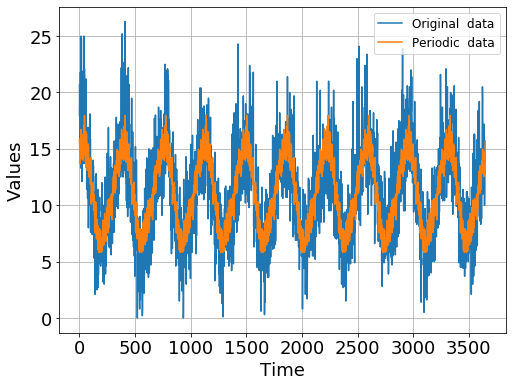

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(x, label="Original  data")
plt.plot(A@z, label="Periodic  data")

plt.legend(fontsize=12)

plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

If your solution is correct, you see that the obtained periodic approximation is **non-smooth**.

To ensure the smoothness in our periodic approximation, consider the following **regularized** least-squares problem:

$$L(z) = ||Az - x||^2 + \lambda R(z) \to \min_z ,$$

where $R(z)$ is some regularization term and $\lambda > 0$.
The term $R(z)$ reflects our additional assumptions on the smoothness of the periodic approximation $z$. One of the possible form of this term is:

$$ R(z) = \sum_{i=1}^m (z_{i+1} - z_i)^2.$$

Another form of the same regularization term is:

$$R(z) =  \|Dz\|_2^2.$$

Intuitevely, the regularization term aims to penalize "sharp" series, and the parameter $\lambda$ provides a trade-off between approximation quality (the first term) and the smoothness degree (the second term). Note, the case $\lambda = 0$ corresponds to the previously obtained solution $z^*$ (why?).
 



_2._ Your second task is to find the best **smooth** periodic approximation $z^*_s$ of the original data $x$.

- (5 pts) Implement function to construct matrix $D$ according to the template provided below. Don't forget about periodicity! What is the meaning of $D$?

if $\lambda = 0$  we obtain the same matrixas we used to have  before.


matrix $D$ helps us to substract from the following X the previous X. So we decrease the variation of X. Also we multiply by $\lambda$ thus we smooth our data

In [48]:
def build_D(m):
    D = -np.eye(m)+np.eye(m, k=1)
    D[m-1, 0]=1
    return D

#   raise NotImplementedError()

D = build_D(z.shape[0])

- (3 pts) The optimality condition for the ordinary least-squares problem was derived during the lecture course. Using the same technique, for a given $\lambda$ derive an analog of the **normal equation** for the regularized least-squares problem formulated above.

$\Vert Az- x \Vert^2_{2}+\lambda \Vert Dz \Vert^2_{2} $


$\nabla \Big( \Vert Az- x \Vert^2_{2}+\lambda \Vert Dz \Vert^2_{2} \Big)= 0$

let's calculate differintial

$d \Big(Az-x, Az-x \Big)+d\lambda\Big(Dz,Dz \Big)=2\Big(Az-x, Adz\Big)+2\lambda\Big(Dz, Ddz\Big) = 2\Big(A^*(Az-x), dz\Big)+2\Big(\lambda D^*Dz, dz\Big) = 2\Big( A^*Az-A^*x+ \lambda D^*Dz, dz\Big) $


$A^*Az-A^*x+\lambda D^*Dz= 0$


$(A^*A+\lambda D^*D)z= A^*x$

- (1 pts) Solve the derived system. You are supposed to use previously constructed matrices $A$ and $D$.

In [49]:
lmbda = 500. # You are supposed to play with parameter $\lambda$ during your study

# Construct system
def zs_func(lmbda):
# z_s = np.linalg.solve(A_inv@A+lmbda*np.transpose(D)@D, A_inv@x)
    q, r= np.linalg.qr(A_inv@A+lmbda*np.transpose(D)@D)
    p = np.transpose(q)@ (A_inv@x)
    z_s=np.linalg.pinv(r)@ p
    return z_s

- (2 pts) Plot the original data $x$ and smooth periodic approximation $Az^*_s$ for three increasing values of $\lambda$. You have to get three plots with two time series $x$ and $Az^*_s$ in every plot. How $\lambda$ affects plots?

the bigger $\lambda$ the smoother solution we have

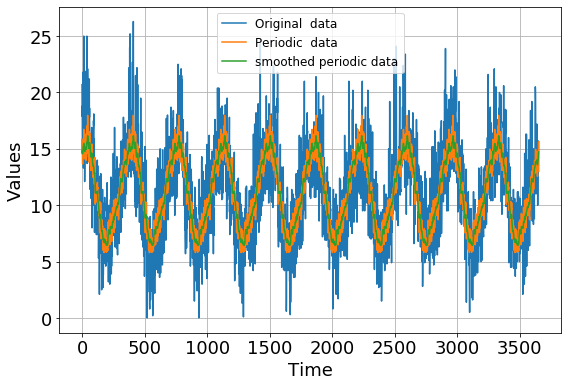

In [56]:
z_s_10= zs_func(10)
z_s_100 = zs_func(100)
z_s_500 = zs_func(500)

plt.figure(figsize=(9, 6))



plt.plot(x, label="Original  data")
plt.plot(A@z, label="Periodic  data")
plt.plot(A @z_s_10, label="smoothed periodic data")
plt.legend(fontsize=12)

plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

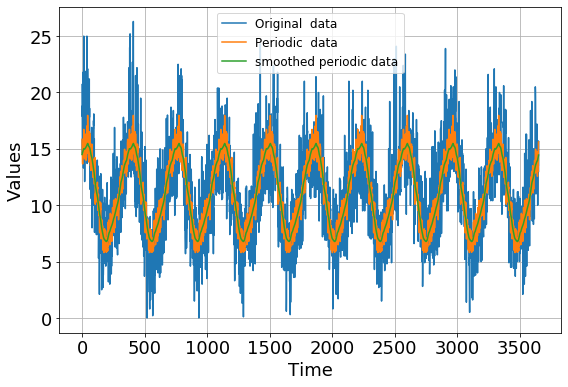

In [59]:
plt.figure(figsize=(9, 6))



plt.plot(x, label="Original  data")
plt.plot(A@z, label="Periodic  data")
plt.plot(A @z_s_100, label="smoothed periodic data")
plt.legend(fontsize=12)

plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

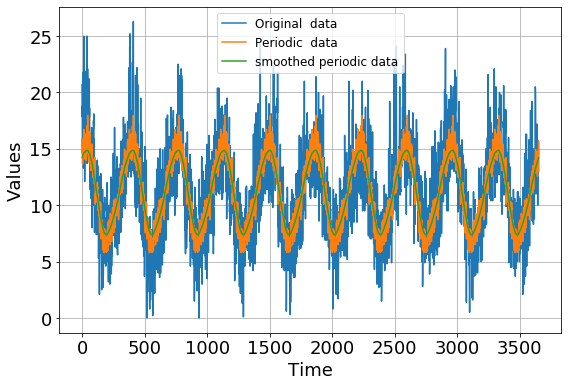

In [60]:
plt.figure(figsize=(9, 6))



plt.plot(x, label="Original  data")
plt.plot(A@z, label="Periodic  data")
plt.plot(A @z_s_500, label="smoothed periodic data")
plt.legend(fontsize=12)

plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

_3._ The final step is to build a model for predicting time series.

_-_ We want to predict $x_{k+1}$ based on $M$ previous observations.

_-_ Consider the following (linear) auto-regression (AR) model:

$$\hat{x}_{k+1} = \theta_1 x_k + \theta_2 x_{k-1} + \ldots + \theta_M x_{k-M+1},$$

with $M$ parameters $\theta_1, \ldots, \theta_M$ to be determined.

_-_ We fit the parameters by minimizing squared norm of the residual (again!):
    
$$(\hat{x}_{M+1} - x_{M+1})^2 + \ldots + (\hat{x}_n - x_n)^2 \to \min_{\mathbf{\theta}}.$$
    
_-_ This problem can be reformulated in a familiar form:

$$||X\theta - x||_2^2 \to \min_{\theta}.$$

- (7 pts) Implement function that constructs matrix $X \in \mathbb{R}^{(n-M) \times M}$ according to the template below. What structure does it have? Use appropriate function from ```NumPy/SciPy``` stack. 


In [62]:
def build_X(x, M):
#     x = x[::-1]
    X = [np.roll(x,-i) for i in range(M)]
    X = np.transpose(X)
    X = np.fliplr(X)
    
#     X[:,1] = np.flip(X[:,1])
    return X[:x.shape[0]-M]
  
#   raise NotImplementedError()

Note, that the previously obtained smooth periodic approximation $z_s$ by itself can be regarded as a predictive model. However, we want to include the noise term in the model too, by fitting it with AR model:

In [63]:
x_n = x - A @ z_s_500 # Extract noise
train_x = x_n[:x_n.shape[0] // 2] #  Train data to fit the model
test_x = x_n[x_n.shape[0] // 2:] #  Test data to validate the model
M = 15 # You are supposed to find the best parameter $M$ during your study
X_train = build_X(train_x, M)

- (3 pts) Once you constructed $X$ based on the training data, the fitting of the parameters $\theta$ again requires the solution of the linear least-squares problem. This time you are supposed to compute pseudoinverse of $X$ via QR decomposition. Hint: use ```numpy.linalg.qr()``` function.

In [64]:
def build_pseudoinverse_QR(A):
    q,r =np.linalg.qr(A)
    return np.linalg.inv(r)@np.transpose(q)
    
#   '''
#     Input: np.array of size (n - M, M)
#     Output: np.array of size (M, n - M)
#   '''  
#   raise NotImplementedError()

X_inv = build_pseudoinverse_QR(X_train)

theta = X_inv @ train_x[M:]

- (3 pts) Check your model with test data. Plot your predicted noise series and test noise series in one plot. Next, add smooth trend $Az_s$ back to predicted noise series and plot it with the original series $x$ in one plot. You have to get two plots with two time series in every plot. Be careful with indexing!

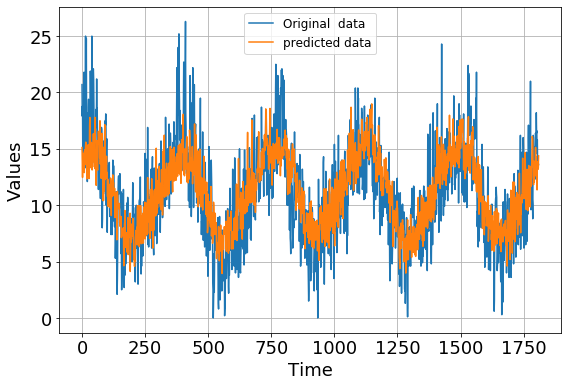

In [74]:
test_X = build_X(test_x,M)
predicted = test_X @ theta

plt.figure(figsize=(9, 6))

plt.plot(x[:1810],  label="Original  data")

plt.plot(predicted+np.tile(z_s_500,5)[:1810], label="predicted data")
plt.legend(fontsize=12)
plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
# plt.plot(A@z_s_500[:1810])

# Plotting

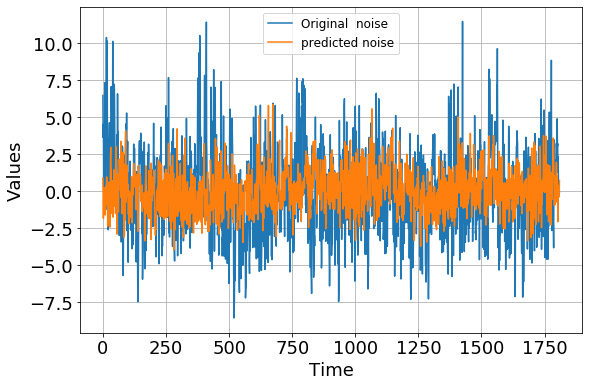

In [80]:
plt.figure(figsize=(9, 6))

plt.plot((x-A @z_s_500)[:1810],  label="Original  noise")

plt.plot(predicted[:1810], label="predicted noise")
plt.legend(fontsize=12)
plt.ylabel("Values", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

- (Bonus) How valuable is your model for real time prediction? Try to perform honest time-marching with your model starting from $x_{M+1}$ to $x_{M+100}$. Is it still good? Try to choose the best parameters $M$ and $\lambda$.


In [2]:
# Your solution is here

# Problem 2 (Theoretical tasks)  (26 pts)

_1._
- (1 pts) what are the constants $C_1$ and $C_2$ such that $C_1 \|x\|_{\infty} \leq \|x\|_2 \leq C_2 \| x\|_{\infty}$
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary matrix $U$.
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

1.1

$C_1 \|x\|_{\infty} \leq \|x\|_2 \leq C_2 \| x\|_{\infty}$

$ \Vert x \Vert_{\infty} = \max_i | x_i| $

$ \Vert x \Vert_2 = \Big(\sum_{i=1}^n |x_i|^2\Big)^{1/2} $

$  \max_i | x_i| \leq \Big(\sum_{i=1}^n |x_i|^2\Big)^{1/2} \leq \sqrt{n}\max_i | x_i|  $

$ C_1 = 1 ;C_2= \sqrt{n}$

1.2

$ \|A\|_F =  \sqrt{trace(A^*A)} $

$ \|UA\|_F =  \sqrt{trace((UA)^*UA)} =  \sqrt{trace((A^*U^*UA)} =  \sqrt{trace(A^*A)}  $

$ \|AU\|_F =  \sqrt{trace((AU)^*AU)} =  \sqrt{trace((U^*A^*AU)} =  \sqrt{trace(UU^*A^*A)} =  \sqrt{trace(A^*A)} $

$ \|A\|_F = \|UA\|_F =  \|AU\|_F $


1.3

$  \Vert A \Vert_{2} = \sup_{\Vert x \Vert_{2} = 1} {\Vert A x \Vert_{2}} $

$  \Vert AU \Vert_{2} = \sup_{\Vert x \Vert_{2} = 1} {\Vert AU x \Vert_{2}} = \sup_{\Vert Ux \Vert_{2} = 1} {\Vert AU x \Vert_{2}} = \sup_{\Vert y\Vert_{2} = 1} {\Vert A y \Vert_{2}} $

$ \Vert UA \Vert_{2} =  \sup_{\Vert x \Vert_{2} = 1} {\Vert UA x \Vert_{2}} = \sup_{\Vert x\Vert_{2} = 1} {\Vert A x \Vert_{2}}  $


2.1

$\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$

$\| A \|_F = \sqrt{\sum_{i}^{rank(A)} \Sigma^{*} \Sigma} = \sqrt{\sum_{i}^{rank(A)} \sigma^2}$

$\| A \|_2 =   max(\sigma) $

$ \sqrt{\sum_{i}^{rank(A)} \sigma^2} \leq \sqrt{\mathrm{rank}(A)} max(\sigma)   $


2.2

When matrix $A$ has a  singular value  $\sigma$ of multiplicity $k = rank(A)$ we get $\sqrt{\sum_{i=1}^k \sigma^2 }= \sigma \sqrt{k} = \sqrt{rank(A)} \|A\|_2$



2.3

from the previous point in this case we obtain that $k = rank(A)= 1$ and  $\sqrt{\sum_{i=1}^k \sigma^2 }= \sqrt{\sum_{i=1}^1 \sigma^2 }= \sigma \sqrt{1} = \sigma=\|A\|_2$

2.4

we consider $b_i$ to be thr $i$ coloumn of $B$

$ \|AB\|_F^{2} = \sum_{i=1}^{n}\|Ab_{i}\|^2_{2} \leq \|A\|_{2}^2\sum_{i=1}^{n}\|b_{i}\|^2_{2} =\|A\|_2^2 \|B\|_F ^2$ 

# Problem 3 (Matrix calculus) (15 pts)

_1._ (5 pts) Consider the following function

$$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2, $$

where $X \in \mathbb{R}^{n \times n}$, $U \in \mathbb{R}^{n \times k}$ and $V \in \mathbb{R}^{k \times n}$ and $k < n$. 

- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $U$ 
- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $V$
- (1 pts) Estimate computational complexity of computing these gradients (in big-O notation). 

_2._ (2 pts) Derive analytical expression for the gradient of the function $f$:

$$ R(x) = \frac{(Ax, x)}{(x, x)}, $$

where $A$ is a symmetric real matrix. Why the gradient of this function is important in NLA you will know in the lectures later.

_3._ (8 pts) Consider the following function $f$ 

$$f(w) = \log\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right),$$

where $x_i, \; i = 1,\dots,m$ are given column vectors. 


- (3 pts) Derive analytical expression for the gradient of $f$\
- (1 pts) For what values of $m$ and vectors $x_i$ the function $f$ makes sense and is finite?
- (4 pts) Consider two approaches to compute it: directly with matrix products and so on and the single-line solution with ```einsum``` function.   
Generate some set of vectors $x_i \in \mathbb{R}^{1000}$ such that the funtion $f$ is finite and compare the time of computing derived gradient with these approaches. Use [%timeit](https://docs.python.org/3.6/library/timeit.html) command to measure time. What do you think about the reason of such behaviour? 

3.1

 
$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2 = \frac{1}{2} tr\Big( (X-UV)^{*}(X-UV)\Big) = \frac{1}{2} tr\Big( (X^{*}-V^{*}U^{*})(X-UV)\Big) = \frac{1}{2} tr\Big( X^{*}X -X^{*}UV-V^{*}U^{*}X-V^{*}U^{*}UV\Big) = \frac{1}{2} \Big( tr(X^{*}X) - tr(X^{*}UV) - tr(V^{*}U^{*}X) - tr(V^{*}U^{*}UV)\Big)$

1


$d_{V}F(U,V) = \frac{1}{2} d_{V} \Big( tr(X^{*}X) - tr(X^{*}UV) - tr(U^{*}X V^{*}) + tr(U^{*}U V V^{*})\Big) = -\frac{1}{2} d_{V} \Big(tr(X^{*}UV) \Big) - \frac{1}{2} d_{V}\Big(tr(U^{*}X V^{*}) \Big) + \frac{1}{2} d_{V} \Big(tr(U^{*}U V V^{*})\Big)= -\frac{1}{2} (I, X^{*}U dV)-\frac{1}{2} (I, U^{*}X (dV)^{*}) + (I, U^{*}U dV V^{*} ) + (I, U^{*}U V dV^{*} ) = (dV, U^{*}U V) - (U^{*}X, dV) = (U^{*}(UV -X),dV)$



$\nabla _{V} F(U,V) = U^{*}(UV -X) $

2

$d_{U}F(U,V) = \frac{1}{2} d_{U} \Big( tr(X^{*}X) - tr(X^{*}UV) - tr(U^{*}X V^{*}) + tr(U^{*}U V V^{*})\Big) = -\frac{1}{2}d_{U}\Big(tr(VX^{*}U) \Big) - \frac{1}{2} d_{U}\Big(tr(X V^{*} U^{*}) \Big) + \frac{1}{2} d_{U} \Big(tr(V V^{*} U^{*}U)\Big) = - \frac{1}{2}  (I, VX^{*}d U)- \frac{1}{2}  (I, XV^{*}(dU)*)+ \frac{1}{2}(I, U^{*}U dV V^{*}) + \frac{1}{2}(I, U^{*}U V (dV)^{*}) = -(XV^{*}, dU) + (UVV^{*},dU) = ((UV-X)V^{*}, dU)$



$\nabla _{U} F(U,V) = (UV-X)V^{*} $

3

the hardest part is the multiplication of 3 matrices so the computatinal complexity is $O(n^3)$
 
3.2


$ R(x) = \frac{(Ax, x)}{(x, x)} $

$ \frac{\delta R(x)}{\delta x_j} = \frac{\frac{\delta (Ax, x)}{\delta x_j}}{(x, x)}  - \frac{(Ax, x)\frac{\delta (x, x)}{\delta x_j} }{(x, x)^2} = \frac{2(Ax)_{j}}{(x, x)}  - \frac{(Ax, x) 2x_{j}}{(x, x)^2} = \frac{2}{(x,x)} \Big( Ax -R(x)x\Big)_{j}$

3.3

1.

$f(w) = \log\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right)$

we  use formula = $\frac{\delta log(det(A))}{\delta x} = trace \Big(A^{-1} \frac{\delta A}{\delta x}\Big)$

so we need to compute the derivative $\frac{\delta \left(\sum_{i=1}^m w_i x_i x_i^{\top}\right)}{\delta w_j}$

$\frac{\delta \left(\sum_{i=1}^m w_i x_i x_i^{\top}\right)}{\delta w_j} = x_j x_j^{\top} $

$ \frac{\delta f(w)}{\delta w_j}= trace\Big(  x_j x_j^{\top} \Big( \sum_{i=1}^m w_i x_i x_i^{\top}\Big)^{-1}\Big)$

2.

for the logarifm we need $\det\left(\sum_{i=1}^m w_i x_i x_i^{\top}\right)>0$.
In determinant we have the sum of m matrices of shape $n \times n$. All these matrices are the rank of 1 cause all the lines linearly dependent due to definition. but if we sum these matrices their rank will increase. so we need $m \geq n$ and we need the requirment for x vectors not to be linearly dependent.

In [1]:

import numpy as np

k = 7
X = np.random.rand(1000,1000)
mat_k = np.outer(X[k], X[k])
mat = X.T @ X
mat_inv = np.linalg.inv(mat)

in this place we assume that $w=(1,.., 1)^T$. we see that for trace operation einsum is quicker. 

In [2]:
%timeit np.einsum('ik, ki', mat_inv, mat_k)
%timeit np.trace(mat_inv @mat_k)

3.38 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
70.1 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Problem 4. Compression of the fully-connected layers in neural network with simple architecture (20 pts)

In this problem we consider the neural network that performs classification of the dataset of images. 
Any neural network can be considered as composition of simple linear and non-linear functions.
For example, a neural network with 3 layers can be represented as 

$$f_3(f_2(f_1(x, w_1), w_2), w_3),$$

where $x$ is input data (in our case it will be images) and $w_i, \; i =1,\dots,3$ are parameters that are going to be trained. 

We will study the compression potential of neural network with simple architecture: alternating some numbers of linear and non-linear functions. 

The main task in this problem is to study how the compression of fully-connected layers affects the test accuracy.
Any fully-connected layer is represented as linear function $AX + B$, where $X$ is input matrix and $A, B$ are trainable matrices. Matrices $A$ in every layer are going to be compressed.
The main result that you should get is the plot of dependence of test accuracy on the total number of parameters in the neural network.

#### Zero step: install PyTorch

- Follow the steps in [official instructions](https://pytorch.org/get-started/locally/)

#### First step: download CIFAR10 dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Check what images are we going to classify

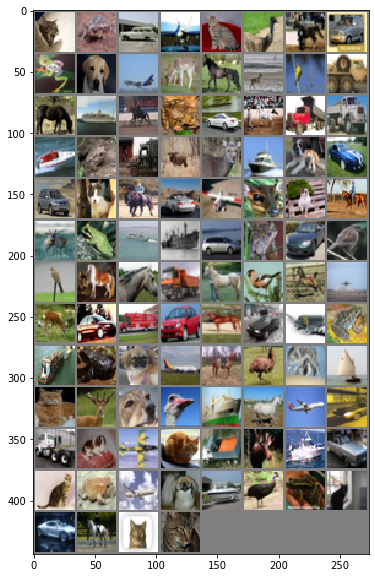

  cat  frog   car plane   cat  bird horse   car


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Second step: neural network architecture

For simplicity and demonstration purposes of the neural network compression idea consider the architecture consisting of the only fully-connected layers and non-linear ReLU functions between them.
To demonstrate compression effect, consider the dimension of the inner layers equals to 1000.

Below you see implementation of such neural network in PyTorch.
More details about neural networks you will study in the *Deep learning* course in one of the upcoming term

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

#### Implement functions for training and testing after every sweep over all dataset entries

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [9]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Set parameters for training and print intermediate loss values

In [10]:
log_interval = 50
epochs = 7

### Third step: run training with the [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) optimization method

If your laptop is not very fast, you will wait some time till training is finished. 

In [11]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303215
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.910230
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.737598
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.883192
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.869320
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.704298
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.002019
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.793734
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.821330
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.514369

Test set: Average loss: 1.5837, Accuracy: 4409/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.538716
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.568555
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.489414
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.437151
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.737079
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.437327
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.539756
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.468039
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.473572
T

Now we have somehow trained neural network and we are ready to perform compression of the weigths in the fully-connected layers.

- (3 pts) Compute SVD of the matrix $1000 \times 1000$, which corresponds to a weight matrix $A$ in any layer of the trained neural network of the appropriate dimension. To find more information about accessing this matrix please refer to [PyTorch manual](https://pytorch.org/docs/stable/index.html).
Plot decaying of the singular values like it was shown in the lecture. What conclusion can you make?
- (12 pts) Create a new model, which is analogue to the class ```Net```, but with some significant distinctions. 
It takes as input parameters the instance of the class ```Net``` and compression rank $r > 0$. 
After that, this model has to compress all matrices $A$ in fully-connected layers with SVD using first $r$ singular vectors and singular values.
Pay attention to efficiently storing of compress representation of the layers.
Also ```forward``` method of your new model has to be implemented in a way to use compressed representation of the fully-connected layers. In all other aspects it has to reproduce ```forward``` method in the original non-compressed model (number of layers, activations, loss function etc).
- (5 pts) Plot dependence of test accuracy on the number of parameters in the compressed model. This number of parameters obviously depends on the compression rank $r$.
Also plot dependence of time to compute inference on the compression rank $r$.
Explain obtained results.
To measure time, use [%timeit](https://docs.python.org/3.6/library/timeit.html) with necessary parameters (examples of using this command see in lectures) 

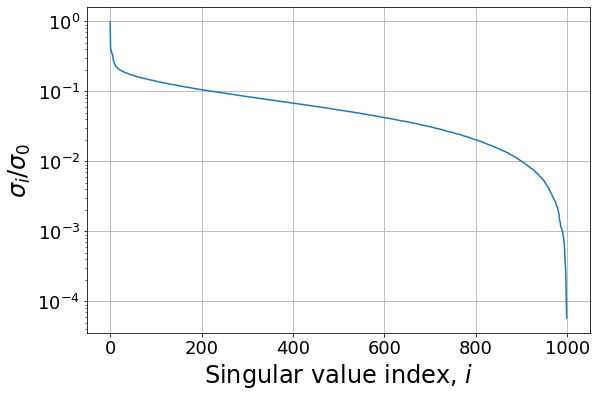

In [82]:
path = './NLA_nat.pth'
torch.save(model.state_dict(), path)
any_layer= model.state_dict()['fc3.weight']
d, s,v =torch.svd(any_layer)

 
    
plt.figure(figsize=(9, 6))


plt.semilogy(s/s[0])

plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)


plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
# Your solution is here

so here we can see that the singular values of the matrix decrease so we can cut only the meaningfull values

In [97]:
model.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])

In [13]:
class netCompressed:
    def __init__(self, net, r):
        super().__init__()
        self.r = r
        layer_weight = self.compressing(net, 'fc1.weight')
        self.fc1 = layer_weight
        self.fc1_bias = net.state_dict()['fc1.bias']
        
                             
        layer_weight = self.compressing(net, 'fc2.weight')
        self.fc2 = layer_weight
        self.fc2_bias = net.state_dict()['fc2.bias']
        
        
        layer_weight = self.compressing(net,'fc3.weight')
        self.fc3 = layer_weight
        self.fc3_bias = net.state_dict()['fc3.bias']
        
        
        layer_weight = self.compressing(net, 'fc4.weight')
        self.fc4 = layer_weight
        self.fc4_bias = net.state_dict()['fc4.bias']
        
        
        layer_weight = self.compressing(net, 'fc5.weight')
        self.fc5 = layer_weight
        self.fc5_bias = net.state_dict()['fc5.bias']
        
        
        layer_weight = self.compressing(net, 'fc6.weight')
        self.fc6 = layer_weight
        self.fc6_bias = net.state_dict()['fc6.bias']
                                         
    def forward(self, x):
        x = x.view(-1, 3 * 32*32)
        
        for layer, b in zip([self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6],
                           [self.fc1_bias, self.fc2_bias, self.fc3_bias, self.fc4_bias, self.fc5_bias, self.fc6_bias]):
            u, s, v = layer
#             print(u.shape, s.shape, v.shape)
            x =  x@v
            x = s.view(1, -1)*x
#             print(x.shape)
            x= x @ u.T
            x = x + b 
            if layer is self.fc6:
                x = F.log_softmax(x, dim=1)
            else:
                x = torch.relu(x)
        
       
        return x
    
    def compressing(self, net, key):
        weight = net.state_dict()[key]
#         print(key, weight.shape)
        u,s,v  = torch.svd(weight)
#         print(u.shape, s.shape, v.shape)
        main_s = s [:self.r]
        main_u = u[:, :self.r]
        main_v = v[:, :self.r]
#         compressed_weight = torch.matmul(torch.matmul(main_u, torch.diag_embed(main_s)), main_v.transpose())
        return main_u, main_s, main_v
   

In [88]:
import time
# %%timeit
rs = list(map(int, torch.logspace(0, 3, 20)))
accs = []
times = []
for r in rs:
    net2 = netCompressed(model, r)
    n_correct = 0
    n_total = 0
    time_total = 0
    for x, y in test_loader:
        time_start = time.time()
#         time = %timeit -n1 -r1 -q -o y_pred = net2.forward(x).argmax(-1, keepdim=False)
        y_pred = net2.forward(x).argmax(-1, keepdim=False)
        time_end = time.time()
        time_total += time_end - time_start
        n_correct += torch.sum(y == y_pred).item()
        n_total += y.shape[0]
    accuracy = n_correct / n_total
    times.append(time_total / n_total)
    accs.append(accuracy)

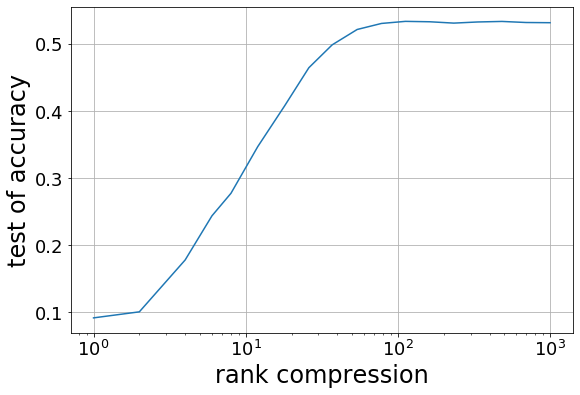

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.semilogx(rs, accs)
# plt.semilogx(rs, times)






plt.ylabel(r"test of accuracy", fontsize=24)
plt.xlabel(r"rank compression", fontsize=24)


plt.grid(True)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

In [16]:
print(torch.sum(y_pred == y))
y.shape[0]

tensor(56)


100

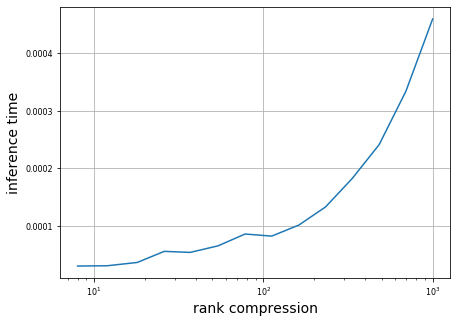

In [95]:



plt.figure(figsize=(7, 5))
plt.semilogx(rs[6:], times[6:])
# plt.semilogx(rs, times)






plt.ylabel(r"inference time", fontsize=14)
plt.xlabel(r"rank compression", fontsize=14)


plt.grid(True)
plt.xticks(fontsize=8)
_ = plt.yticks(fontsize=8)
plt.show()
plt.show()

the more we compress the more time it takes per one operation

In [33]:
it = iter(train_loader)
x = next(it)[0]

In [92]:
res.average

0.00047696000183350407

# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```

5.1.
we consider the norm like that
$\|X\|_{ANYA}\sum_{i=2}^{n}|x_{i}-x_{i-1}|+\sum_{i=1}^{n}|x_{i}|$
we can check the norm properties:


1.
$\|X\|_{ANYA}>=0$ (due to definition of the modul)


2.
$\|\lambda X\|_{ANYA} = \sum_{i=2}^{n}|\lambda x_{i}-\lambda x_{i-1}|+\sum_{i=1}^{n}|\lambda x_{i}|= |\lambda|\sum_{i=2}^{n}|x_{i}-x_{i-1}|+\sum_{i=1}^{n}|x_{i}| = |\lambda|\|X\|_{ANYA}$


3.
$\|X+Y\|_{ANYA}= \sum_{i=2}^{n}|x_{i}+y_{i}-(x_{i-1}+y_{i-1})|+\sum_{i=1}^{n}|x_{i}+y_{i}|= \sum_{i=2}^{n}|x_{i}-x_{i-1}+y_{i}-y_{i-1})|+\sum_{i=1}^{n}|x_{i}+y_{i}| \leq \sum_{i=2}^{n} \Big( |x_{i}-x_{i-1}|+|x_{i}|+|y_{i}-y_{i-1}|+|y_{i}|\Big)=\|X\|_{ANYA}+\|Y\|_{ANYA}$

here is an  example for $n=3$

$x=(1, -2, -3)^T$ and $\lvert x \lvert = (\lvert 1\lvert,\lvert -2 \lvert ,\lvert -3 \lvert)^T$

for $x$ $\|X\|_{ANYA}=|-2-1|+|-3+2|+|1| +6=11$


for $x$ $\| |X| \|_{ANYA}=|2-1|+|3-2|+|1|+6=9$